# Import Required Packages

In [43]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import mnist_reader

# Import DPU Overlay and Loading the .xmodel

In [44]:
#Type your code here

#Import the DPU Overlay and load the .xmodel

from pynq_dpu import DpuOverlay
overlay = DpuOverlay('dpu.bit')
overlay.load_model('quantized_model.xmodel')



# Loading the Fashion MNIST Dataset

In [45]:
fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

In [46]:
#Type your code here

path_to_data = 'data/fashion'

x_test, y_test = mnist_reader.load_mnist(path_to_data, kind='t10k')
x_test = x_test.astype('float32')/255 #feature scaling (Hint:255 is the maximum pixel value)


print("Total number of test images: {}".format(x_test.shape[0]))
print("Shape of each image: {}".format(x_test.shape[1:]))


Total number of test images: 10000
Shape of each image: (784,)


# Running the Quantized Model

In [47]:
#Type your code here

dpu_runner = overlay.runner #Access the Runner object

inputTensors = dpu_runner.get_input_tensors() #get input tensors
outputTensors = dpu_runner.get_output_tensors() #get output tensors

shapeIn = inputTensors[0].dims
shapeOut = outputTensors[0].dims

print('Input shape:', shapeIn)
print('Output shape:', shapeOut)

Input shape: [1, 28, 28, 1]
Output shape: [1, 10]


In [48]:
#Type your code here

num_pics = x_test.shape[0] #Number of images in the test set
prediction = np.zeros(num_pics, dtype=np.int)    #Initiate a np.zeros() array to store the predicted class index
output_data = np.empty(shapeOut, dtype=np.float32)     #Initiate an np.empty() array to store the FPGA output

#A for loop to loop through the images and make predictions
for i in tqdm(range(num_pics)):
    input_data = x_test[i].reshape(shapeIn)  #The input image, reshape it to shapeIn
    job_id = dpu_runner.execute_async(input_data, output_data)   #Make a prediction by calling execute_async()
    dpu_runner.wait(job_id) #Wait until the job is complete
    score = output_data.ravel()   #Flatten the output_data using .ravel()
    prediction[i] = score.argmax()  #Find the index of maximum score as our prediction, using .argmax()
    
print('accuracy:', np.mean(prediction == y_test))

100%|██████████| 10000/10000 [00:07<00:00, 1411.91it/s]

accuracy: 0.9166


# Timing Operations

In [49]:
input_data = x_test[0].reshape(shapeIn)
output_data = np.empty(shapeOut, dtype=np.float32)

In [50]:
%%timeit -o -r 1000 -n 1 -q

#Type your code here
job_id = dpu_runner.wait(dpu_runner.execute_async(input_data, output_data)) #Make a prediction and time it, remember to call the .wait() method


<TimeitResult : 1 loop, best of 1000: 647 µs per loop>

In [51]:
#Calculate the Frame Rate in Frames Per Second(FPS)
result = _
print('FPS:',1/np.mean(result.all_runs))

FPS: 1528.4114337853255


# Plotting the Result

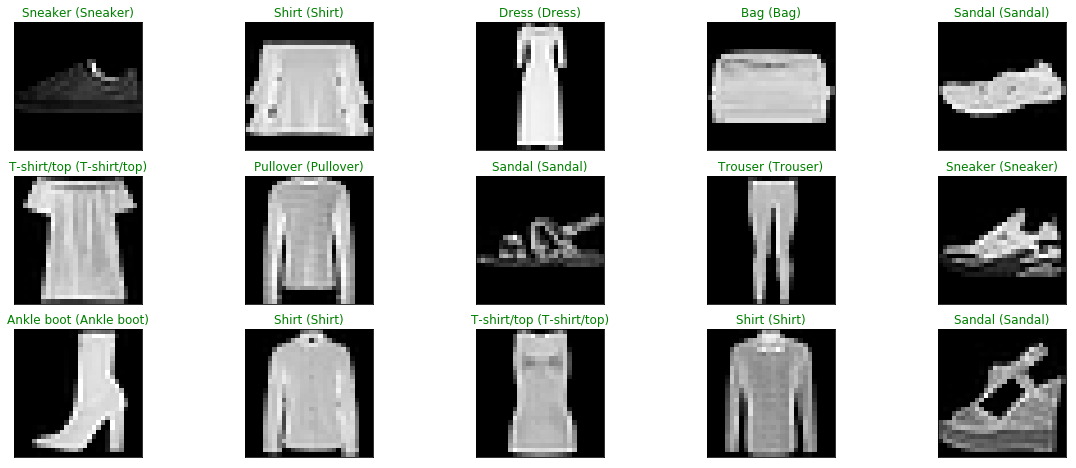

In [52]:
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = prediction[index]
    true_index = y_test[index]
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                fashion_mnist_labels[true_index]),
                color=("green" if predict_index == true_index else "red"))